<a href="https://colab.research.google.com/github/roy392/cautious-goggles/blob/main/KLasifikasi_bunga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Klasifikasi gambar atau mengimport tool yang akan digunakan

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# download data set 
Tutorial ini menggunakan dataset sekitar 3.700 foto bunga. Dataset berisi lima sub-direktori, satu per kelas:

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 8s 0us/step


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Setelah mengunduh, Anda sekarang harus memiliki salinan kumpulan data yang tersedia. Ada total 3.670 gambar:

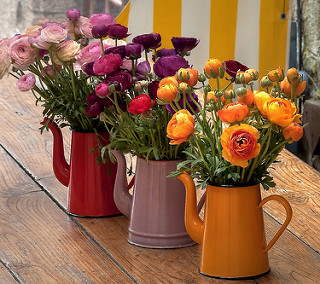

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

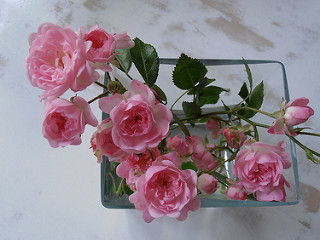

In [10]:
PIL.Image.open(str(roses[1]))

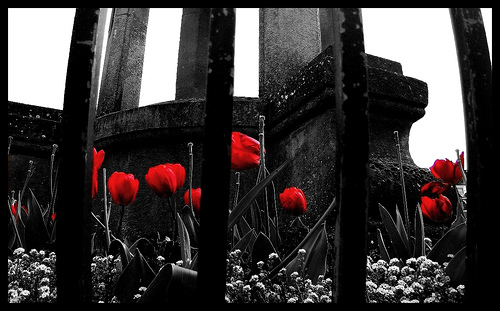

In [11]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

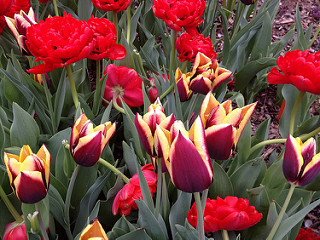

In [12]:
PIL.Image.open(str(tulips[1]))

# Buat kumpulan data

Tentukan beberapa parameter untuk loader

In [13]:
batch_size = 32
img_height = 180
img_width = 180

 saya menggunakan pemisahan validasi saat mengembangkan model  menggunakan 80% gambar untuk pelatihan dan 20% untuk validasi.

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Menentukan kelas

In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualisasikan datanya
sembilan gambar pertama dari dataset pelatihan

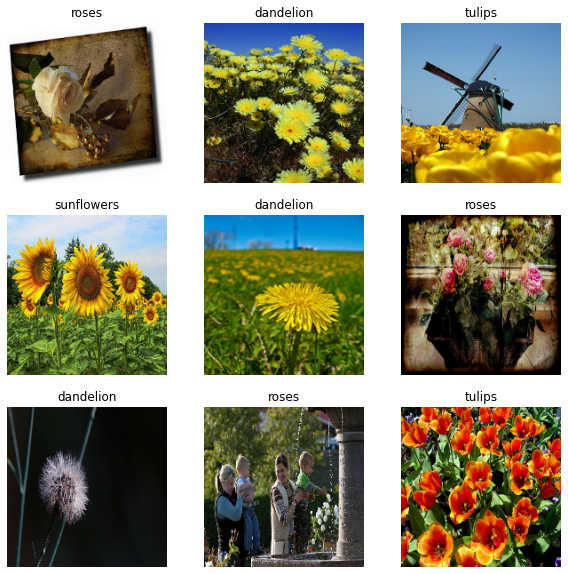

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


 tensor image_batchdari bentuk (32, 180, 180, 3). Ini adalah sekumpulan 32 gambar bentuk 180x180x3(dimensi terakhir mengacu pada saluran warna RGB). Ini label_batchadalah tensor dari bentuk (32,), ini adalah label yang sesuai dengan 32 gambar.

Anda dapat memanggil .numpy()dan tensor image_batchuntuk labels_batchmengonversinya menjadi file numpy.ndarray. 
hasil

# Konfigurasikan set data untuk performa

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarisasi data
Nilai saluran RGB berada dalam [0, 255]kisaran. saraf; menentukan nilai kecil
membakukan nilai agar berada dalam [0, 1]rentang dengan menggunakan tf.keras.layers.Rescaling:

In [20]:
normalization_layer = layers.Rescaling(1./255)

Ada dua cara untuk menggunakan lapisan ini. Anda dapat menerapkannya ke kumpulan data dengan memanggil Dataset.map

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model Keras dasar
## Buat modelnya
Model Keras Sequential terdiri dari tiga blok konvolusi ( tf.keras.layers.Conv2D) dengan max pooling layer ( tf.keras.layers.MaxPooling2D) di masing-masing blok. Ada lapisan yang sepenuhnya terhubung ( tf.keras.layers.Dense) dengan 128 unit di atasnya yang diaktifkan oleh fungsi aktivasi ReLU ( 'relu'). Model ini belum disetel untuk akurasi tinggi; tujuan dari tutorial ini adalah untuk menunjukkan pendekatan standar.

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Kompilasi modelnya
Untuk mengotimalkan pilih fungsi tf.keras.optimizers.Adampengoptimal dan tf.keras.losses.SparseCategoricalCrossentropykerugian. Untuk melihat akurasi pelatihan dan validasi untuk setiap periode pelatihan, teruskan metricsargumen ke Model.compile.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Ringkasan model
untuk melihat model Jumlah parameter
Parameter yang dapat dilatih
parameter yang tidak dapat dilatih

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Latih modelnya

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 109s 1s/step - loss: 1.2946 - accuracy: 0.4489 - val_loss: 1.0458 - val_accuracy: 0.5899
Epoch 2/10
92/92 [==============================] - 101s 1s/step - loss: 0.9609 - accuracy: 0.6291 - val_loss: 0.9661 - val_accuracy: 0.6199
Epoch 3/10
92/92 [==============================] - 100s 1s/step - loss: 0.7485 - accuracy: 0.7180 - val_loss: 0.8689 - val_accuracy: 0.6553
Epoch 4/10
92/92 [==============================] - 101s 1s/step - loss: 0.5289 - accuracy: 0.8007 - val_loss: 0.9344 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 101s 1s/step - loss: 0.2947 - accuracy: 0.8982 - val_loss: 0.9991 - val_accuracy: 0.6730
Epoch 6/10
92/92 [==============================] - 102s 1s/step - loss: 0.1822 - accuracy: 0.9384 - val_loss: 1.2010 - val_accuracy: 0.6662
Epoch 7/10
92/92 [==============================] - 101s 1s/step - loss: 0.1042 - accuracy: 0.9700 - val_loss: 1.3067 - val_accuracy: 0.6635
Epoch 8/10
92

# Visualisasikan hasil pelatihan

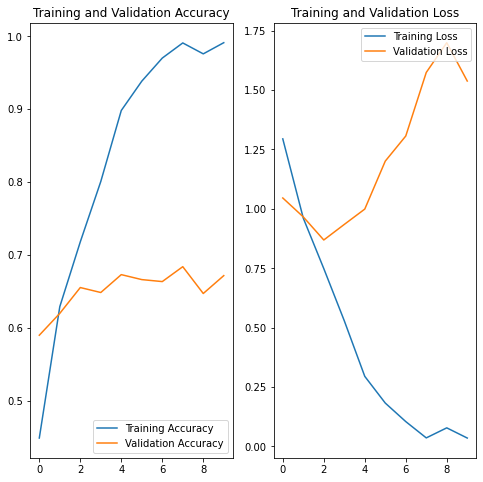

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Plot menunjukkan bahwa akurasi pelatihan dan akurasi validasi meleset dengan margin yang besar, dan model hanya mencapai akurasi sekitar 60% pada set validasi.

# Overfitting
Dalam plot di atas, akurasi pelatihan meningkat secara linier dari waktu ke waktu, sedangkan akurasi validasi terhenti sekitar 60% dalam proses pelatihan. Selain itu, perbedaan akurasi antara akurasi pelatihan dan validasi terlihat—tanda overfitting .

Ketika ada sejumlah kecil contoh pelatihan, model terkadang belajar dari kebisingan atau detail yang tidak diinginkan dari contoh pelatihan—hingga berdampak negatif pada performa model pada contoh baru. Fenomena ini dikenal sebagai overfitting. Ini berarti bahwa model akan mengalami kesulitan menggeneralisasi dataset baru.

## augmentasi data
Overfitting umumnya terjadi ketika ada sejumlah kecil contoh pelatihan. maka harus mengunkan argumen data biar bisa dioptimalkan gambar tersebut

In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

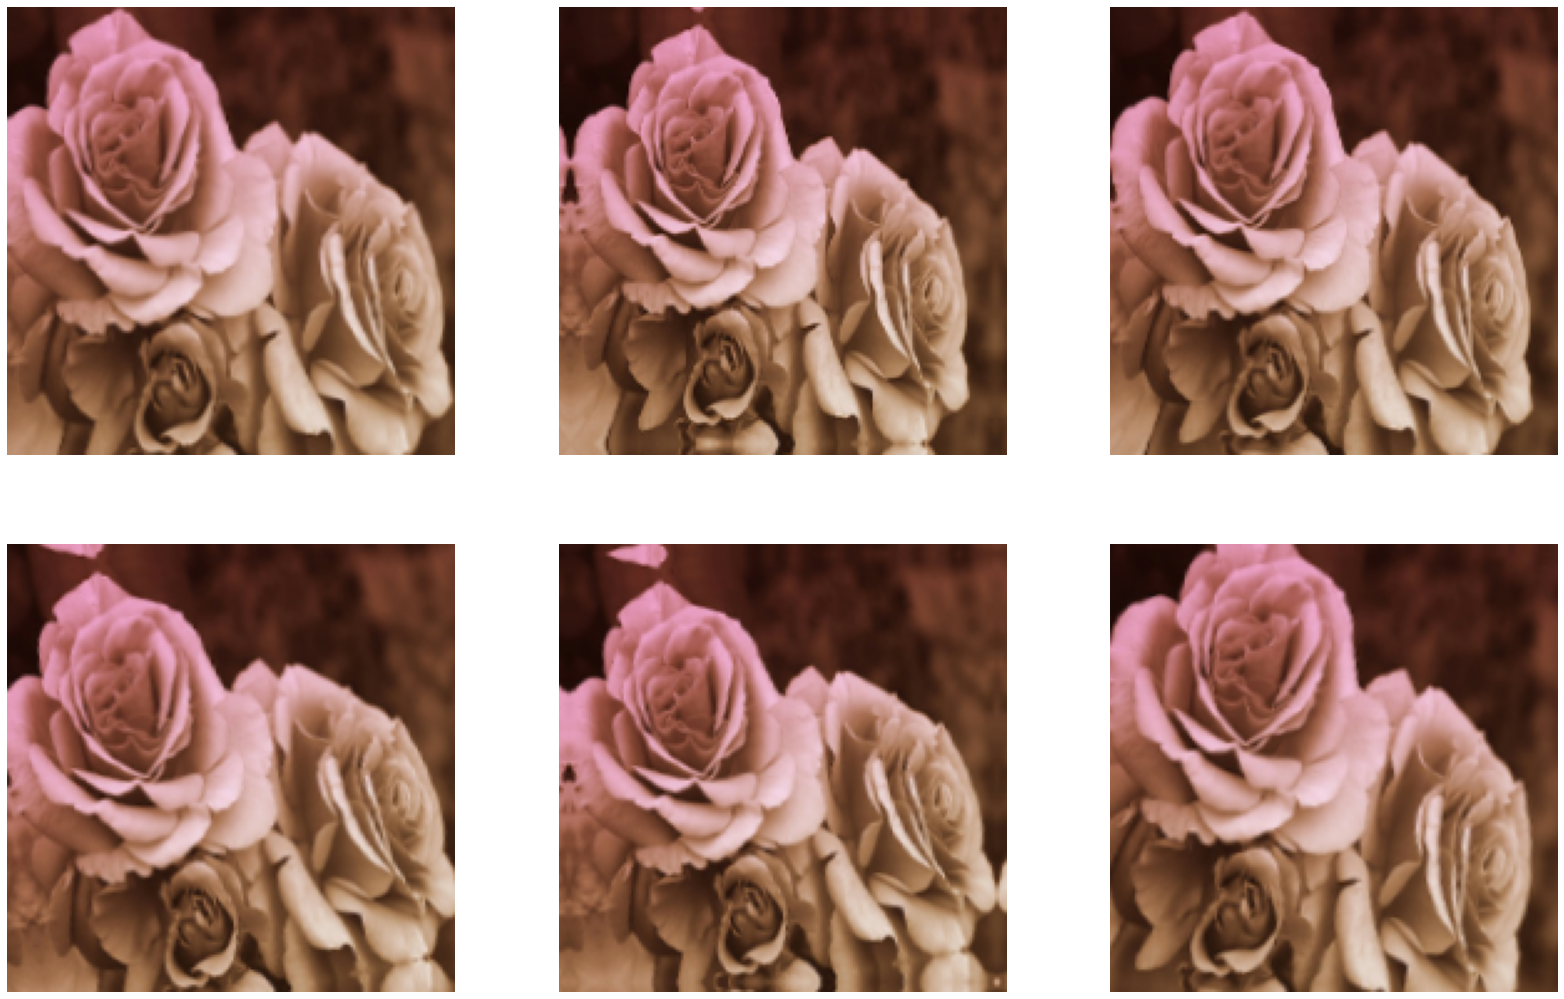

In [28]:
plt.figure(figsize=(28, 28))
for images, _ in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Keluar
Teknik lain untuk mengurangi overfitting adalah dengan memperkenalkan regularisasi dropout {:.external} ke jaringan.

Ketika ingin menerapkan dropout ke sebuah layer, secara acak dropout (dengan menyetel aktivasi ke nol) sejumlah unit keluaran dari layer selama proses pelatihan. Dropout mengambil angka pecahan sebagai nilai inputnya, dalam bentuk seperti 0.1, 0.2, 0.4, dll. Ini berarti menjatuhkan 10%, 20% atau 40% unit output secara acak dari lapisan yang diterapkan.

Buat jaringan saraf baru tf.keras.layers.Dropout sebelum melatihnya menggunakan gambar yang diperbesar:

In [29]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Mengulang Kompilasi dan latih model biar mendapatkan hasil maksimal

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 119s 1s/step - loss: 1.4152 - accuracy: 0.3873 - val_loss: 1.1195 - val_accuracy: 0.5409
Epoch 2/15
92/92 [==============================] - 115s 1s/step - loss: 1.0830 - accuracy: 0.5579 - val_loss: 1.0617 - val_accuracy: 0.5763
Epoch 3/15
92/92 [==============================] - 116s 1s/step - loss: 0.9699 - accuracy: 0.6240 - val_loss: 0.9101 - val_accuracy: 0.6376
Epoch 4/15
92/92 [==============================] - 116s 1s/step - loss: 0.8877 - accuracy: 0.6543 - val_loss: 0.8681 - val_accuracy: 0.6798
Epoch 5/15
92/92 [==============================] - 117s 1s/step - loss: 0.8271 - accuracy: 0.6812 - val_loss: 0.8158 - val_accuracy: 0.6826
Epoch 6/15
92/92 [==============================] - 117s 1s/step - loss: 0.7931 - accuracy: 0.6866 - val_loss: 0.7526 - val_accuracy: 0.7016
Epoch 7/15
92/92 [==============================] - 117s 1s/step - loss: 0.7395 - accuracy: 0.7187 - val_loss: 0.8272 - val_accuracy: 0.6894
Epoch 8/15
92

## Visualisasikan hasil pelatihan
Setelah menerapkan augmentasi data dan tf.keras.layers.Dropout, overfitting lebih sedikit daripada sebelumnya, dan akurasi pelatihan dan validasi lebih selaras:

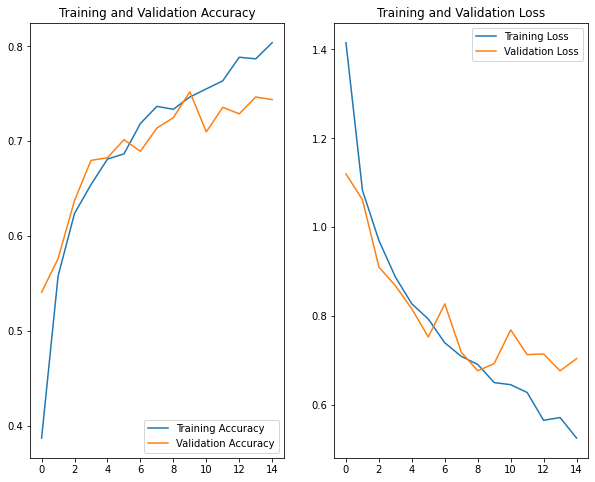

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()